# Importing Libraries

In [1]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [2]:
%run "Stock Data.ipynb".ipynb
%run "Binance API.ipynb".ipynb
%run "RiskMetrics.ipynb".ipynb

# Importing Data

## Tickers

In [3]:
binance_api_key=''
binance_api_secret=''
Binance=BinanceAPI(binance_api_key,binance_api_secret)

In [4]:
#stocks=pd.read_html('https://en.wikipedia.org/wiki/EURO_STOXX_50')[4]
#tickers=stocks['Ticker'].to_list()

## Market Data

In [5]:
start_date=datetime.datetime(2023,12,1)
enddate=start_date+datetime.timedelta(500)

In [6]:
tickers=Binance.get_market_cap()['Ticker'].iloc[:75].to_list()
holding=Binance.get_inventory()
condition=holding.index!='Total'
holding_tickers=holding.index[condition]
holding_tickers=holding_tickers.to_list()
tickers=sorted(list(set(tickers+holding_tickers)))

In [7]:
data1=Binance.get_price(tickers,start_date)
data2=Binance.get_price(tickers,enddate)
data=data1.combine_first(data2)
data.index=pd.to_datetime(data.index)
#data=data.dropna(axis=1)
n=len(data.columns)

In [8]:
inventory_weights=(holding['Weights in %'].apply(lambda x: np.round(x,2))/100).to_dict()
inventory_weights.pop('Total')
inventory_weights

{'BTCUSDT': 0.39409999999999995,
 'JASMYUSDT': 0.1784,
 'ETHUSDT': 0.1399,
 'SOLUSDT': 0.1127,
 'MKRUSDT': 0.0638,
 'BBUSDT': 0.0552,
 'PEPEUSDT': 0.0338,
 'BNBUSDT': 0.022099999999999998,
 'FETUSDT': 0.0,
 'TRXUSDT': 0.0}

In [9]:
returns=np.log(1+data.pct_change())
returns.index=pd.to_datetime(returns.index)
with_no_na=returns.columns[np.where((returns.isna().sum()<30))]
returns_to_use=returns[with_no_na]
ex_ante_perf=returns[holding_tickers]
ex_ante_perf_to_use=ex_ante_perf.dropna()

In [10]:
weights_post=dict()

for col in ex_ante_perf.columns:
    
    if col in inventory_weights.keys():
        weights_post[col]=inventory_weights[col]
        
    else:
        weights_post[col]=0
    
current_weights=np.array(list(weights_post.values()))

### Positions

In [11]:
positions=Binance.get_positions_history(enddate=datetime.datetime.today()-datetime.timedelta(1))
positions=positions.sort_index()

positions['Total']=positions.sum(axis=1)
weights_ex_post=positions.copy()
weights_ex_post=weights_ex_post.apply(lambda x: x/weights_ex_post['Total']).fillna(0)

2024-05-05 00:00:00
2024-06-04 00:00:00
LDUMAUSDT not retrieved


In [12]:
binance_data=Binance.get_price(positions.columns,date=datetime.datetime(2024,5,5))
binance_data=np.log(1+binance_data.pct_change())

LDUMAUSDT not retrieved
Total not retrieved


In [13]:
historical_ptf=pd.DataFrame()

In [14]:
for col in binance_data:
    historical_ptf[col]=weights_ex_post[col]*binance_data[col]

<AxesSubplot:>

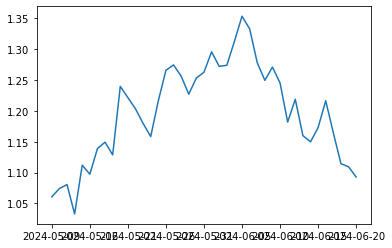

In [15]:
historical_ptf.dropna(axis = 0, how = 'all', inplace = True)
(1+historical_ptf.sum(axis=1)).cumprod().plot()

In [52]:
historical_ptf

,BTCUSDT,ETHUSDT,RNDRUSDT,SOLUSDT,TRXUSDT,UMAUSDT,FDUSDUSDT,FETUSDT,INJUSDT,MKRUSDT,...,BBUSDT,BNBUSDT,NEARUSDT,PEPEUSDT,XRPUSDT,ARUSDT,ENSUSDT,JASMYUSDT,LPTUSDT,NOTUSDT
2024-05-09,0.004975,0.003357,0.015061,0.012801,4.345600e-03,2.021738e-02,0.0,0.000000e+00,0.000000e+00,0.000000,...,NaN,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,NaN
2024-05-11,0.000087,0.000123,0.000139,-0.000300,-3.094985e-04,6.356087e-03,0.0,-4.309074e-04,-4.291790e-03,0.000672,...,NaN,0.000000e+00,-0.000000,0.000000,0.000000e+00,-0.000000,0.000000,-0.000000,0.000000,NaN
2024-05-13,0.003572,0.000788,0.004948,0.009216,-3.855061e-04,-4.954349e-03,-0.0,-7.991113e-04,-2.432474e-03,-0.000179,...,NaN,-0.000000e+00,0.000000,0.000000,0.000000e+00,-0.000000,-0.000000,0.000000,-0.000000,NaN
2024-05-14,-0.005748,-0.002265,-0.011792,-0.010959,-3.015615e-05,-5.775102e-03,0.0,-1.987902e-03,-3.222928e-03,-0.000033,...,-0.000000,-0.000000e+00,-0.000000,0.000000,-0.000000e+00,-0.000000,-0.000000,-0.000000,-0.000000,NaN
2024-05-15,0.018971,0.004751,0.005887,0.032719,1.628214e-04,1.009513e-04,-0.0,4.226007e-03,5.725377e-03,0.002002,...,0.000000,0.000000e+00,0.000000,-0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,NaN
2024-05-16,-0.003863,-0.002698,-0.005556,0.001623,-2.501359e-04,-1.083827e-03,0.0,4.129031e-04,-4.156475e-04,-0.001744,...,-0.000000,-0.000000e+00,-0.000000,-0.000000,-0.000000e+00,0.000000,-0.000000,-0.000000,-0.000000,NaN
2024-05-17,0.006995,0.004530,0.000306,0.019041,-1.198900e-04,3.244329e-04,0.0,9.923848e-04,3.105801e-03,0.001395,...,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,-0.000000,-0.000000
2024-05-18,-0.000441,0.000982,0.002509,0.005764,-2.574513e-04,-3.980637e-04,-0.0,-1.098931e-03,0.000000e+00,0.000600,...,0.000000,-0.000000e+00,-0.000000,-0.000000,-0.000000e+00,-0.000000,0.000000,0.000000,-0.000000,-0.000000
2024-05-19,-0.002577,-0.001612,-0.002689,-0.004708,-3.446154e-04,-2.090417e-03,-0.0,-1.222659e-03,-2.018469e-03,-0.000728,...,-0.000000,-0.000000e+00,-0.000000,-0.000000,-0.000000e+00,0.000000,-0.000000,-0.000000,-0.000000,-0.000000
2024-05-20,0.019664,0.018350,0.007522,0.030599,5.699099e-04,2.422101e-03,0.0,3.435004e-03,9.910568e-03,0.005892,...,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,-0.000000,0.000000,0.000000,0.000000,0.000000


### Ex ante data

In [16]:
ex_ante_ptf=ex_ante_perf.copy()

for key in inventory_weights.keys():
    
    ex_ante_ptf[key]=ex_ante_perf[key]*inventory_weights[key]

ex_ante_ptf=pd.DataFrame(ex_ante_ptf.sum(axis=1))

# Portfolio Optimization

In [17]:
historical_risk=RiskAnalysis(returns_to_use)
current_risk=RiskAnalysis(ex_ante_perf_to_use)
num_asset=len(returns_to_use.columns)
num_asset_current=len(ex_ante_perf_to_use.columns)

In [18]:
returns_to_use.columns

Index(['AAVEUSDT', 'ADAUSDT', 'AGIXUSDT', 'ALGOUSDT', 'APTUSDT', 'ARBUSDT',
       'ARUSDT', 'ATOMUSDT', 'AVAXUSDT', 'AXSUSDT', 'BCHUSDT', 'BNBUSDT',
       'BONKUSDT', 'BTCUSDT', 'DOGEUSDT', 'DOTUSDT', 'DYDXUSDT', 'EGLDUSDT',
       'ENSUSDT', 'EOSUSDT', 'ETCUSDT', 'ETHUSDT', 'FDUSDUSDT', 'FETUSDT',
       'FILUSDT', 'FLOKIUSDT', 'FLOWUSDT', 'FTMUSDT', 'GALAUSDT', 'GNOUSDT',
       'GRTUSDT', 'HBARUSDT', 'ICPUSDT', 'IMXUSDT', 'INJUSDT', 'JASMYUSDT',
       'LDOUSDT', 'LINKUSDT', 'LTCUSDT', 'MATICUSDT', 'MKRUSDT', 'NEARUSDT',
       'NEOUSDT', 'OPUSDT', 'ORDIUSDT', 'PENDLEUSDT', 'PEPEUSDT', 'QNTUSDT',
       'RNDRUSDT', 'RUNEUSDT', 'SANDUSDT', 'SEIUSDT', 'SHIBUSDT', 'SOLUSDT',
       'STXUSDT', 'SUIUSDT', 'THETAUSDT', 'TIAUSDT', 'TRXUSDT', 'UNIUSDT',
       'USDCUSDT', 'VETUSDT', 'WBETHUSDT', 'WBTCUSDT', 'XLMUSDT', 'XRPUSDT',
       'XTZUSDT'],
      dtype='object')

In [19]:
ex_ante_perf_to_use.columns

Index(['BTCUSDT', 'JASMYUSDT', 'ETHUSDT', 'SOLUSDT', 'MKRUSDT', 'BBUSDT',
       'PEPEUSDT', 'BNBUSDT', 'FETUSDT', 'TRXUSDT'],
      dtype='object')

## Optimal Portfolio

In [50]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'ineq', 'fun': lambda weights: weights[21]-0.15},
                                                           {'type': 'ineq', 'fun': lambda weights: weights[13]-0.3}])
opt_weights=np.round(opt_weights,6)
inventory=historical_risk.inventory(opt_weights)
inventory

,Weights
BTCUSDT,0.300000
BNBUSDT,0.239969
ETHUSDT,0.150000
JASMYUSDT,0.121597
PENDLEUSDT,0.107682
PEPEUSDT,0.080752


In [51]:
current_optimal_weights=current_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'ineq', 'fun': lambda weights: weights[0]-0.3},
                                                           {'type': 'ineq', 'fun': lambda weights: weights[2]-0.15}])
current_optimal_weights=np.round(current_optimal_weights,6)
optimal_ptf_current=current_risk.inventory(current_optimal_weights)
optimal_ptf_current

,Weights
JASMYUSDT,0.46228
BTCUSDT,0.30000
ETHUSDT,0.23772


## Real Portfolio vs Optimal

In [22]:
current_holding_comparison=holding.copy()
current_holding_comparison=current_holding_comparison.loc[current_holding_comparison.index!="Total"]
current_holding_comparison=pd.concat([current_holding_comparison,optimal_ptf_current*100],axis=1)
current_holding_comparison['Spread']=current_holding_comparison['Weights in %']-current_holding_comparison['Weights']
current_holding_comparison=current_holding_comparison.fillna(0)
current_holding_comparison

,Price in USDT,Weights in %,Weights,Spread
BTCUSDT,683.300825,39.411082,30.000,9.411082
JASMYUSDT,309.232351,17.835748,46.228,-28.392252
ETHUSDT,242.627303,13.994136,23.772,-9.777864
SOLUSDT,195.448951,11.273007,0.000,0.000000
MKRUSDT,110.612475,6.379851,0.000,0.000000
BBUSDT,95.624636,5.515390,0.000,0.000000
PEPEUSDT,58.551789,3.377121,0.000,0.000000
BNBUSDT,38.357085,2.212341,0.000,0.000000
FETUSDT,0.011871,0.000685,0.000,0.000000
TRXUSDT,0.011093,0.000640,0.000,0.000000


In [23]:
historical_comparison=holding.copy()
historical_comparison=historical_comparison.loc[historical_comparison.index!="Total"]
historical_comparison=pd.concat([historical_comparison,inventory*100],axis=1)
historical_comparison['Spread']=historical_comparison['Weights in %']-historical_comparison['Weights']
historical_comparison=historical_comparison.fillna(0)
historical_comparison

,Price in USDT,Weights in %,Weights,Spread
BTCUSDT,683.300825,39.411082,30.0000,9.411082
JASMYUSDT,309.232351,17.835748,14.3812,3.454548
ETHUSDT,242.627303,13.994136,0.0000,0.000000
SOLUSDT,195.448951,11.273007,0.0000,0.000000
MKRUSDT,110.612475,6.379851,0.0000,0.000000
BBUSDT,95.624636,5.515390,0.0000,0.000000
PEPEUSDT,58.551789,3.377121,10.2551,-6.877979
BNBUSDT,38.357085,2.212341,19.3642,-17.151859
FETUSDT,0.011871,0.000685,0.0000,0.000000
TRXUSDT,0.011093,0.000640,0.0000,0.000000


## Risk Reward Analysis

<AxesSubplot:>

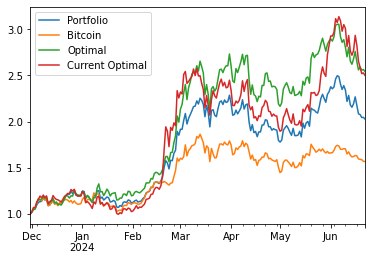

In [24]:
opt_ptf=(returns_to_use*opt_weights).sum(axis=1)
curr_opt_ptf=(ex_ante_perf*current_optimal_weights).sum(axis=1)
portfolio_perf=pd.DataFrame()
portfolio_perf['Portfolio']=(ex_ante_perf*current_weights).sum(axis=1)
portfolio_perf['Bitcoin']=returns['BTCUSDT']
portfolio_perf['Optimal']=opt_ptf
portfolio_perf['Current Optimal']=curr_opt_ptf
(1+portfolio_perf).cumprod().plot()

In [25]:
vol=historical_risk.portfolio(opt_weights).std()*np.sqrt(252)

vol

Portfolio    0.553036
dtype: float64

In [26]:
portfolio_perf.iloc[1:].std()*np.sqrt(252)

Portfolio          0.501360
Bitcoin            0.442310
Optimal            0.554360
Current Optimal    0.675087
dtype: float64

In [27]:
perf_analysis=pd.concat([historical_risk.perf_contrib_pct(opt_weights),historical_risk.var_contrib_pct(opt_weights)],axis=1)
perf_analysis

,Performance Contribution in %,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BNBUSDT,0.172532,0.181095,0.110837,0.031252,0.079585
BTCUSDT,0.116117,0.190707,0.203834,0.057295,0.146539
ETCUSDT,0.003207,0.062751,0.151440,0.036196,0.115244
JASMYUSDT,0.245817,0.204440,0.193442,0.089680,0.103762
PENDLEUSDT,0.189327,0.157147,0.146163,0.048129,0.098034
PEPEUSDT,0.273000,0.203860,0.194283,0.066828,0.127455


In [28]:
perf_analysis=pd.concat([current_risk.perf_contrib_pct(current_weights),current_risk.var_contrib_pct(current_weights)],axis=1)
perf_analysis

,Performance Contribution in %,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BTCUSDT,0.051782,0.374579,0.222390,0.068286,0.154104
JASMYUSDT,1.238657,0.238863,0.301043,0.145166,0.155877
ETHUSDT,0.367578,0.152884,0.121765,0.022785,0.098979
SOLUSDT,-0.225167,0.093433,0.109981,0.017374,0.092607
MKRUSDT,-0.115322,0.053585,0.056210,0.005922,0.050288
BBUSDT,-0.327298,0.033387,0.140755,0.042926,0.097829
PEPEUSDT,0.021063,0.033074,0.035952,0.005361,0.030592
BNBUSDT,-0.011294,0.020196,0.011904,0.000348,0.011556


## Value At Risk

### Historical

In [29]:
var,cvar=historical_risk.historical_var(opt_weights)
(var,cvar)

(-0.051406848196219226, -0.06994123447721551)

In [30]:
var,cvar=current_risk.historical_var(current_weights)
(var,cvar)

(-0.041534704752692844, -0.04908753121254187)

### Parametric

In [31]:
var,cvar=historical_risk.parametric_var(opt_weights)

(var,cvar)

(-0.05744056702555633, -0.07362292548954649)

In [32]:
var,cvar=current_risk.parametric_var(current_weights)

(var,cvar)

(-0.05362000904967213, -0.0687260264902405)

### Multivariate

In [33]:
perf=performance(historical_risk.multivariate_distribution(),opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.052035614626162775, -0.06562148762115341)

In [34]:
perf=performance(current_risk.multivariate_distribution(),current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.05166394570582747, -0.06500372023409974)

### Copulas

In [35]:
cop=historical_risk.gaussian_copula()
perf=performance(cop,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.05166036477442542, -0.06556327706871587)

In [36]:
cop=current_risk.gaussian_copula()
perf=performance(cop,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.05274744553209841, -0.06657765705225804)

In [37]:
t_copula=historical_risk.t_copula()
perf=performance(t_copula,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.0527890459457187, -0.06759154750367642)

In [38]:
t_copula=current_risk.t_copula()
perf=performance(t_copula,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.05206125361144164, -0.06651374611906247)

### Monte Carlo

In [39]:
spot=data[with_no_na].iloc[-1]
monte_carlo=historical_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1],opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.059850381256896776, -0.07443229568967698)

In [40]:
spot=data[ex_ante_perf.columns].iloc[-1]
monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1],current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.05669917659435934, -0.06925129098413085)

### VaR Violation

In [41]:
var_data=rolling_var(returns_to_use,opt_weights,window=15,Q=1)
var_data

,Historical,Parametric,Multivariate,Portfolio
2023-12-30,-0.030516,-0.057070,-0.051384,-0.001067
2023-12-31,-0.030516,-0.057266,-0.053727,-0.005867
2024-01-01,-0.029577,-0.057504,-0.049368,0.039050
2024-01-02,-0.029577,-0.059245,-0.051661,-0.015840
2024-01-03,-0.040734,-0.065980,-0.060567,-0.042262
...,...,...,...,...
2024-06-18,-0.051702,-0.073970,-0.083394,-0.033855
2024-06-19,-0.051702,-0.067562,-0.076543,0.012239
2024-06-20,-0.051702,-0.067050,-0.078681,-0.013092
2024-06-21,-0.051702,-0.067217,-0.078409,0.002607


In [42]:
current_var_data=rolling_var(ex_ante_perf,current_weights,window=5,Q=1)
current_var_data

,Historical,Parametric,Multivariate,Portfolio
2024-05-18,-0.032180,-0.108642,-0.095943,0.007965
2024-05-19,-0.027759,-0.105299,-0.091976,-0.026019
2024-05-20,-0.027759,-0.122381,-0.106730,0.100429
2024-05-21,-0.025276,-0.113844,-0.091851,-0.007458
2024-05-22,-0.025276,-0.115485,-0.100623,-0.003023
2024-05-23,-0.025361,-0.118210,-0.106040,-0.009562
2024-05-24,-0.009478,-0.111128,-0.095170,-0.004927
2024-05-25,-0.009478,-0.041556,-0.040069,0.033314
2024-05-26,-0.009377,-0.055753,-0.044460,0.041455
2024-05-27,-0.009377,-0.052670,-0.036360,0.019371


<AxesSubplot:>

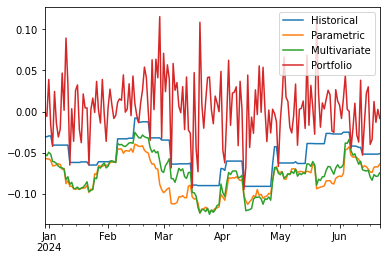

In [43]:
var_data.plot()

<AxesSubplot:>

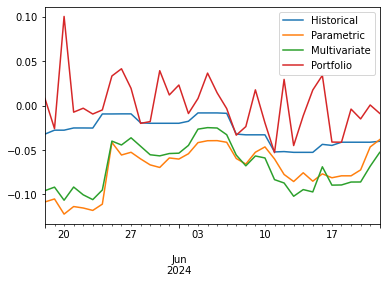

In [44]:
current_var_data.plot()

In [45]:
kupiec_test(var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.056818,0.0,0.0
Kupiec Stat,0.165301,18.05524,18.05524
P-value,0.684323,0.000021,0.000021


In [46]:
kupiec_test(current_var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.111111,0.0,0.0
Kupiec Stat,2.132718,3.693117,3.693117
P-value,0.144185,0.054637,0.054637


## Principal Component Analysis

In [47]:
eigval,eigvec,portfolio_components=historical_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.75988774, 0.08067627, 0.06278584, 0.04908857, 0.04756158])

In [48]:
eigval,eigvec,portfolio_components=current_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.58654927, 0.18497182, 0.10980883, 0.08702205, 0.03164802])

### Creating Benchmarks

<AxesSubplot:>

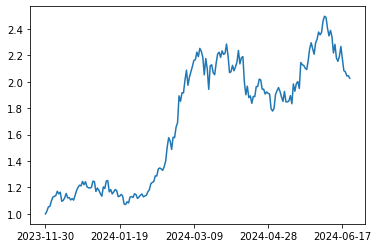

In [49]:
tr1=Binance.get_price(list(inventory_weights.keys()),start_date)
tr2=Binance.get_price(list(inventory_weights.keys()),enddate)
tr=tr1.combine_first(tr2).sort_index()

test_returns=np.log(1+tr.pct_change())
test_ptf=test_returns.copy()

for key in inventory_weights.keys():
    
    test_ptf[key]=test_ptf[key]*inventory_weights[key]

(1+test_ptf.sum(axis=1)).cumprod().plot()